# Using PyMC with levy-stable-jax

This notebook shows how to use PyMC to infer posterior distributions based on some samples. We will do the following:

- generate some samples from a distribution with known parameters
- recover these parameters through a maximum-likelihood estimate
- recover the posterior distribution over the parameters

The `levy-stable-jax` package includes a distribution object for PyMC. It is highly recommended that you use the `numpyro` MCMC at this point. `numpyro` can take advantage of distributions written in JAX and can dramatically accelerate your sampling iterations.

If you want to run this notebook, you need the following packages:

- arviz
- pymc
- levy-stable-jax
- numpyro

You can install them with the pip command: `pip install levy-stable-jax[pymc]`

In [1]:
import seaborn as sns
from scipy.stats import levy_stable as sp_levy_stable
import numpy as np
import arviz as az
import pymc.sampling_jax
import pymc as pm

import jax
import levy_stable_jax.pymc
import levy_stable_jax.estimation

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
np.random.seed(2)

We generate first some samples of an alpha-stable distribution. You can try various values to see what happens.

The sample distribution shows the characteristic behaviour of alpha-stable distributions: some skewness towards positive value (`beta_true > 0`), a large concentration of samples around the mean (close to `loc_true`) with a few extreme values very far off. This is the sort of empirical distribution that would be unwise to fit with a Normal distribution.

In [3]:
alpha_true = 1.4
beta_true = 0.5
loc_true = 3.0
scale_true = 2.0

prng = jax.random.PRNGKey(1)
xs = levy_stable_jax.rvs(
    alpha=alpha_true, 
    beta=beta_true,
    loc=loc_true,
    scale=scale_true,
    prng=prng,
    param="N0",
    shape=(500,))


Alternatively, these samples could be generated from scipy's [levy_stable](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levy_stable.html) module. The following code accomplishes this. A few differences to note:

- the key of the random generator always has to be provided with JAX
- the parametrization is implicit in scipy. It is highly recommended to make it explicit.

The sampler from `levy_stable_jax` can be significantly faster than `scipy`'s as well.

In [4]:
with levy_stable_jax.set_stable("N0"):
    _xs = sp_levy_stable.rvs(alpha=alpha_true, 
                            beta=beta_true,
                            loc=loc_true,
                            scale=scale_true,
                            size=500)

<Axes: ylabel='Count'>

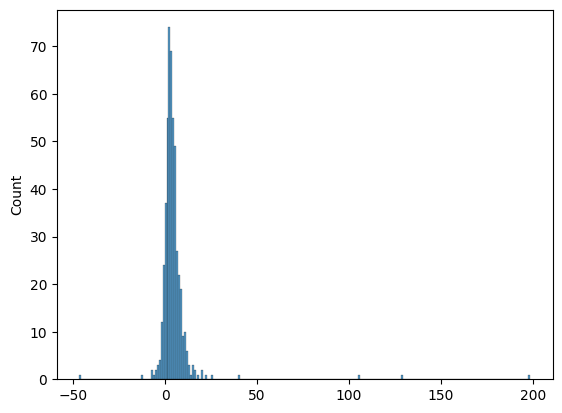

In [5]:
sns.histplot(xs)

We first start by doing a maximum likelihood estimate. You are encouraged to try 
the `fit` function in `scipy` to compare the speed.

It is highly recommended to always specify the parametrization being used. For the estimation algorithms, the choice has little impact: the `N0` parametrization will always be used internally for maximum stability, and the results will be converted to the chosen parametrization before being returned. In this case, we will use the `N0` parametrization.

As you can see, the inferred parameters are pretty close to the original distribution's parameters.

In [6]:
levy_stable_jax.estimation.fit_ll(samples=xs,param="N0")

Array([1.49873435, 0.62188098, 2.94672355, 2.12081734], dtype=float64)

We now infer full posterior distributions over the parameters. Even if there 
is no close form solution, MCMC samplers such as provided by PyMC will 
provide excellent results with little work.

Each parameter needs a prior distribution. Without knowing anything, we do the following choices:

- the scale's prior is a half-normal distribution (positive prior which is common for Gaussian distributions' standard deviations)
- the location prior is Normal to constraint the choice. We could also have a heavy tail distribution such as a Cauchy, it does not change the results
- alpha (concentration) must be between 1.1 and 2. Without knowing much, a uniform distribution is reasonable
- beta (skewness) must be between -1 and 1. This parameter is very challenging to MCMC samplers when values get close to 1 or -1. It is recommended to chose a smaller interval, as below.

Finally, we provide the observed values. This is it!

In [7]:
with pm.Model() as model0:
    scale = pm.HalfNormal("scale", sigma=10)
    loc = pm.Normal("loc", mu=0.0, sigma=20)
    alpha = pm.Uniform("alpha", lower=1.2, upper=2.0)
    beta = pm.Uniform("beta", lower=-0.85, upper=0.85)
    # Our distribution
    x = levy_stable_jax.pymc.LevyStableN0("x", alpha, beta, loc, scale, observed=xs)

As recommended, we use the `numpyro` sampler that integrates with JAX. 

It is recommended to have a longer tuning phase; this really seems to help to achieve good convergence. With the choice of parameters above, the acceptance rate is high and there is no need to further tune the sampler.

In [8]:
with model0:
    idata = pm.sampling_jax.sample_numpyro_nuts(draws=4000, tune=6000)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Finally, inspecting the results, we see that the true parameters are very likely values in the posterior distributions. More samples would increase the confidence around the true values.

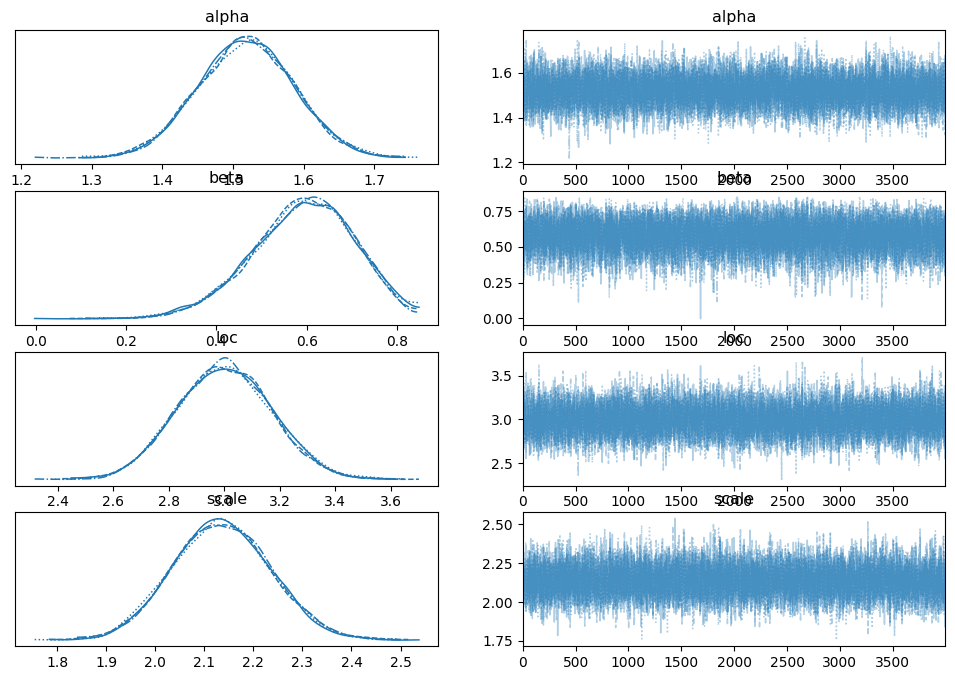

In [9]:
az.plot_trace(idata);

In [10]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.519,0.068,1.393,1.648,0.001,0.000,11689.0,9966.0,1.0
beta,0.591,0.112,0.385,0.798,0.001,0.001,10869.0,6444.0,1.0
loc,3.001,0.170,2.688,3.319,0.002,0.001,12063.0,11175.0,1.0
scale,2.135,0.099,1.952,2.321,0.001,0.001,13029.0,11336.0,1.0


The MCMC approach has a few advantages for modellers:

- if the distribution is Normal, the posterior distribution of alpha will be highly concentrated and skewed around 2.0. This can be used as a test of normal distribution
- this algorithm is quite fast and it provides confidence intervals around the values, which can give a good level of confidence on the nature of the disribution